<a href="https://colab.research.google.com/github/massinoLight/ProjetNedra/blob/main/projetNedra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterisation non supervisée d'images
 Dans ce notbook nous essayons de combiner deux methodes de ML 
 l'une qui est suppérvisé c'est (la partie CNN)afin d'extraire les caractéristiques propre a une image 
 la seconde est le k-means afin de faire le clustering des vecteurs issues du premier traitement de CNN  

##Architecture de notre modéle 

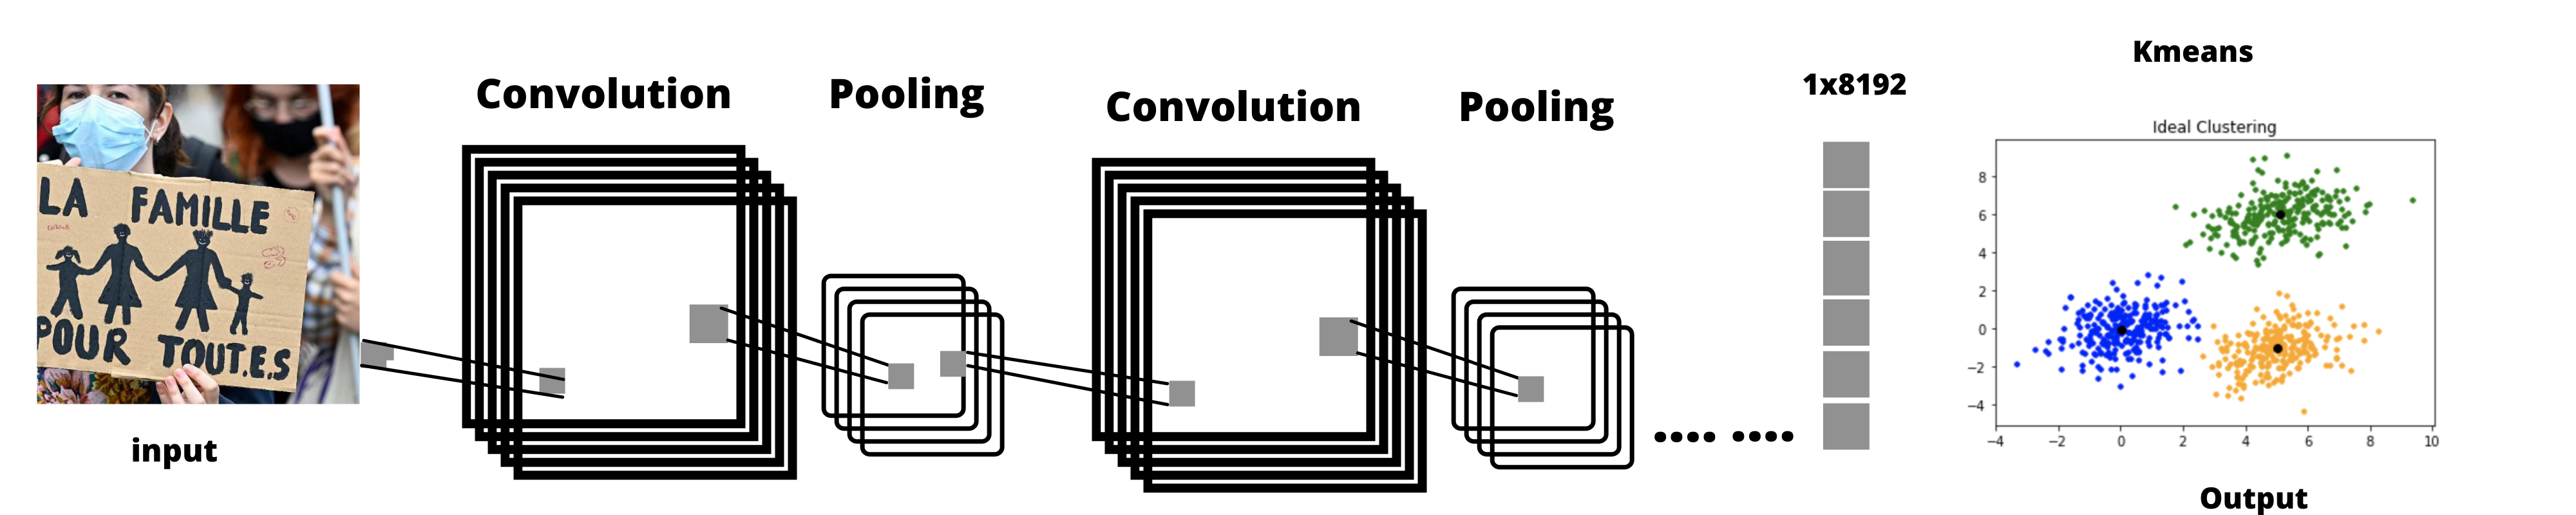

Le réseau de neurones convolutifs (CNN) est l'unes
des architectures de réseaux de neurones artificiels feed-forward
fréquemment utilisé dans les problèmes de vision par ordinateur tels que l'image
classification. La différence entre CNN et multicouche
réseau perceptron (MLP) est son utilisation de la convolution
couches, regroupement et non-linéarités telles que tanh, sigmoïde,
et ReLU

On va récupérer notre jeux de données de kaggle (le jeux de données contient des photos issues de twitter )

Nous l'avons upload sur Kaggle pour faciliter son chargement 

In [94]:
 !pip install -q kaggle

In [ ]:
!pip install requests

In [95]:
!pip install -q tfds-nightly

In [96]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"amassinnacerddine","key":"2d285aa8e3751d9a4ec861d6bc2ddb67"}'}

In [97]:
 ! mkdir ~/.kaggle 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [98]:
! kaggle datasets download  'amassinnacerddine/projetnedra-mt-an'

projetnedra-mt-an.zip: Skipping, found more recently modified local copy (use --force to force download)


In [100]:
! unzip projetnedra-mt-an.zip

Archive:  projetnedra-mt-an.zip
replace 1/00008871284d1fa8b6d188d7cffe4714c9b8bcab.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [103]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from tensorflow.keras import layers
import shutil
from tensorflow import keras
from keras import backend
import cv2
import sys
import requests
from tensorflow.keras.applications import ResNet101V2
from matplotlib import pyplot
from PIL import Image 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [112]:
import pathlib


data_dir = pathlib.Path('/content/1/')
datagen = ImageDataGenerator(rescale=1./255)

In [113]:
data_dir

PosixPath('/content/1')

In [115]:
# Création des chemins d'extraction
import os

zip_path = '/content/projetnedra-mt-an.zip'
extract_path = '/content/datasets/'
images_path = os.path.join(extract_path,'pma_images')

In [116]:
# Extraction de l'archive
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!rm -rf /content/dataset/

In [106]:

image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)


897


In [118]:
batch_size = 200
# La taille des images est adapté au modèle pré-entraîné
img_height = 64
img_width = 64

generator = datagen.flow_from_directory(extract_path, seed=2, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None)
batch=generator[0]

Found 3863 images belonging to 1 classes.


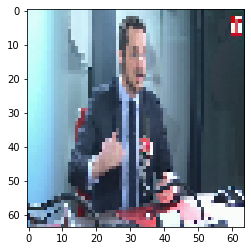

In [120]:
pyplot.imshow(batch[1])




In [ ]:
import os
os.path.join(data_dir,'images')

'/content/1/images'

In [ ]:
 !mkdir /content/dataset

##Split directory into train test and validation 60% 20% 20%

In [121]:
conv_base = ResNet101V2(include_top=False,input_shape=(64,64,3))

In [122]:
model=tf.keras.models.Sequential([
                                  conv_base,tf.keras.layers.Flatten()

])

In [123]:
model.compile()

In [124]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2, 2, 2048)        42626560  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
Total params: 42,626,560
Trainable params: 42,528,896
Non-trainable params: 97,664
_________________________________________________________________


In [125]:
result_cnn=model.predict(batch)

In [127]:

len(result_cnn)

200

In [174]:
import numpy as np
import tensorflow as tf



def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(result_cnn, dtype=tf.float32), num_epochs=1)

num_clusters = 32
kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 100
previous_centers = None
for x in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
  previous_centers = cluster_centers
  print ('score:', kmeans.score(input_fn))
print ('cluster centers:', cluster_centers)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj8cj3y35', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

In [175]:
# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(result_cnn):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print ('image:', point, 'is in cluster', cluster_index, 'centered at', center)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8cj3y35/model.ckpt-199
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
image: [0.         0.40509966 0.         ... 0.         0.         0.        ] is in cluster 12 centered at [0.         0.05063745 0.5108335  ... 1.6522405  0.         0.        ]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 1 centered at [0.         0.         2.4805493  ... 0.80497414 0.         0.14517936]
image: [0.         4.590459   0.         ... 0.34289402 0.         0.        ] is in cluster 28 centered at [0.03819504 0.25831553 0.10774094 ... 3.5354426  0.5625732  0.4951588 ]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 10 centered at [0.14515865 0.         0.24493152 ... 1.3826624  0.16100155 0.25010803]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 27 centered at [0.32142085 0.0364528  0.         ... 0.         0

In [130]:
len(cluster_indices)

200

In [176]:
np.arange(batch_size)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [177]:
import math

def draw_folder(folder):
  columns = 8
  rows = math.ceil(len(folder)/columns)
  fig = pyplot.figure(figsize=(25, rows*3))
  index = 1
  for i in folder:
      img = batch[i]
      sub_plot = fig.add_subplot(rows, columns, index)
      index = index + 1
      sub_plot.axis('off')
      sub_plot.set_title(i)
      pyplot.imshow(img)
  pyplot.show()

In [178]:
table=np.dstack((np.arange(batch_size),cluster_indices))
table

array([[[  0,  12],
        [  1,   1],
        [  2,  28],
        [  3,  10],
        [  4,  27],
        [  5,   3],
        [  6,  27],
        [  7,  21],
        [  8,  28],
        [  9,  10],
        [ 10,   9],
        [ 11,  28],
        [ 12,   3],
        [ 13,  27],
        [ 14,   2],
        [ 15,  28],
        [ 16,   4],
        [ 17,   9],
        [ 18,  10],
        [ 19,   2],
        [ 20,   1],
        [ 21,  29],
        [ 22,   3],
        [ 23,   3],
        [ 24,  27],
        [ 25,  28],
        [ 26,  12],
        [ 27,  27],
        [ 28,  14],
        [ 29,  21],
        [ 30,  28],
        [ 31,  10],
        [ 32,   3],
        [ 33,   3],
        [ 34,   0],
        [ 35,   3],
        [ 36,  10],
        [ 37,   5],
        [ 38,  30],
        [ 39,  27],
        [ 40,  28],
        [ 41,   4],
        [ 42,   2],
        [ 43,   5],
        [ 44,  10],
        [ 45,  27],
        [ 46,   8],
        [ 47,  28],
        [ 48,  27],
        [ 49,  21],


In [180]:
class1=[]
class2=[]
class3=[]
for i in range(0,len(table[0])-1):
  if table[0][i][1]==1:
    class1.append(table[0][i][0])
  else:
    if table[0][i][1]==2:
      class2.append(table[0][i][0])
    else:
      if table[0][i][1]==3:
        class3.append(table[0][i][0])  

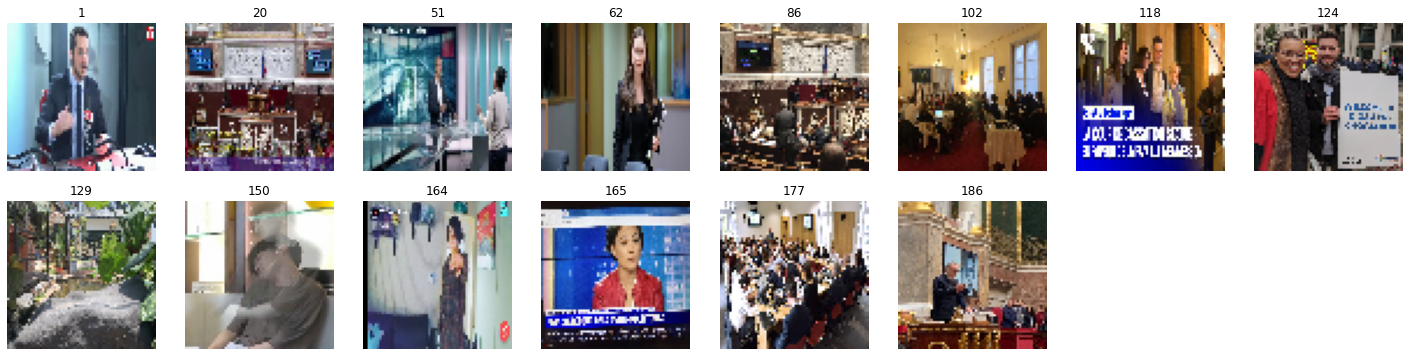

In [181]:
draw_folder(class1)

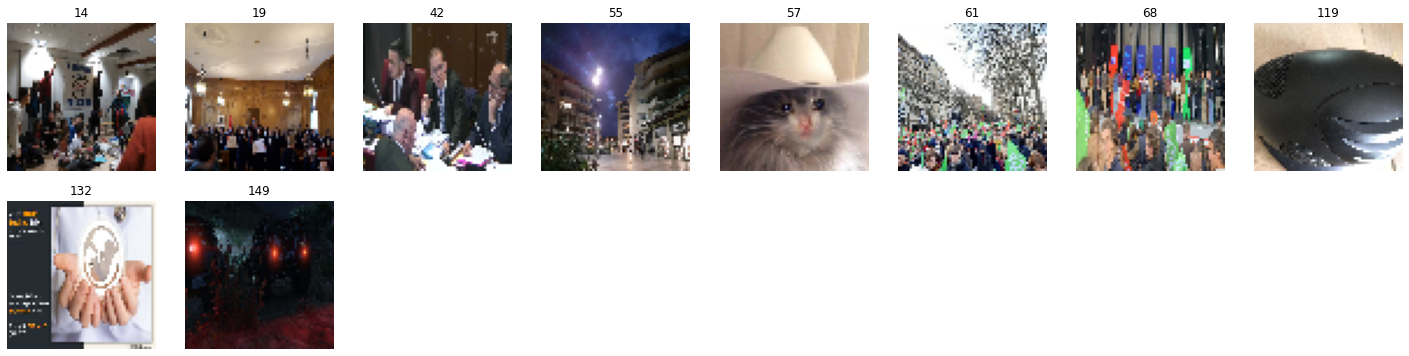

In [182]:
draw_folder(class2)

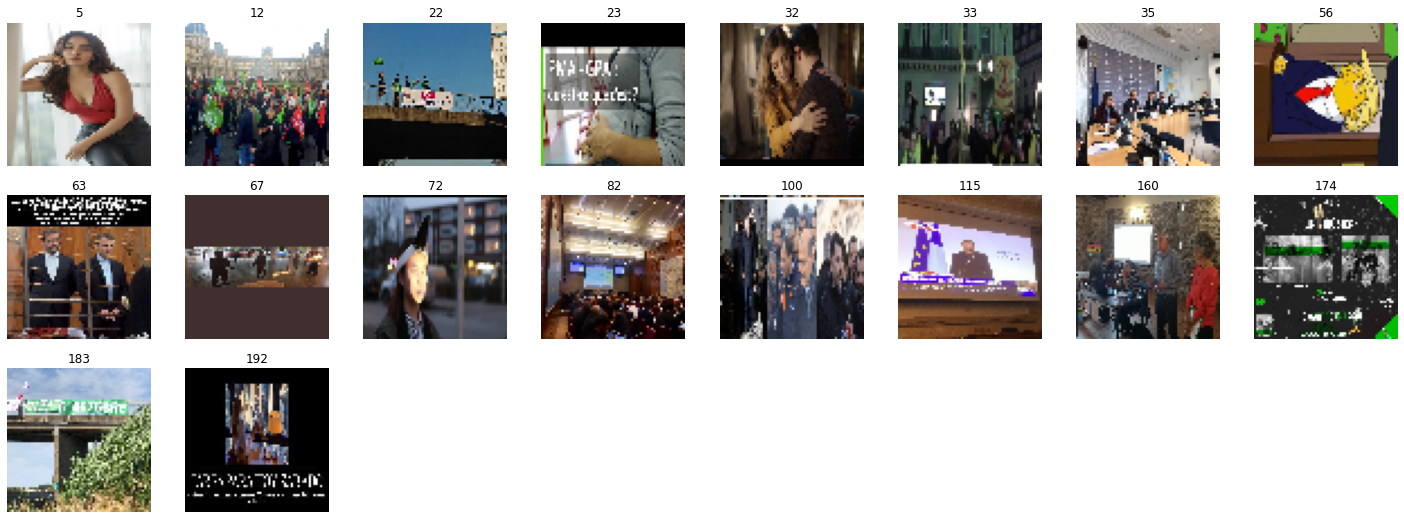

In [183]:
draw_folder(class3)

In [186]:
import matplotlib.pyplot as plt
import random

number_of_colors = 32

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(color)

['#98F8F3', '#6E521F', '#2D1BE7', '#E61C33', '#269E70', '#3C8D4C', '#D22757', '#BFB93E', '#74FC17', '#234B7B', '#27B1AD', '#ED9AAB', '#7BFC2A', '#240678', '#801F1B', '#AEE4C5', '#9E1D8A', '#95A4B1', '#DD7B72', '#91BAD5', '#63487B', '#B7EBDF', '#EE36F4', '#A77F82', '#522A36', '#6D347C', '#227248', '#F52610', '#E5B331', '#D3AE71', '#2DBE0A', '#830FE3']


In [188]:
def print_class(value):
    cases = {
        0: lambda: pyplot.scatter(point[0],point[1], c = color[0]),
        1: lambda: pyplot.scatter(point[0],point[1], c = color[1]),
        2: lambda: pyplot.scatter(point[0],point[1], c = color[2]),
        3: lambda: pyplot.scatter(point[0],point[1], c = color[3]),
        4: lambda: pyplot.scatter(point[0],point[1], c = color[4]),
        5: lambda: pyplot.scatter(point[0],point[1], c = color[5]),
        6: lambda: pyplot.scatter(point[0],point[1], c = color[6]),
        7: lambda: pyplot.scatter(point[0],point[1], c = color[7]),
        8: lambda: pyplot.scatter(point[0],point[1], c = color[8]),
        9: lambda: pyplot.scatter(point[0],point[1], c = color[9]),
        10: lambda: pyplot.scatter(point[0],point[1], c = color[10]),
        11: lambda: pyplot.scatter(point[0],point[1], c = color[11]),
        12: lambda: pyplot.scatter(point[0],point[1], c = color[12]),
        13: lambda: pyplot.scatter(point[0],point[1], c = color[13]),
        14: lambda: pyplot.scatter(point[0],point[1], c = color[14]),
        15: lambda: pyplot.scatter(point[0],point[1], c = color[15]),
        16: lambda: pyplot.scatter(point[0],point[1], c = color[16]),
        17: lambda: pyplot.scatter(point[0],point[1], c = color[17]),
        18: lambda: pyplot.scatter(point[0],point[1], c = color[18]),
        19: lambda: pyplot.scatter(point[0],point[1], c = color[19]),
        20: lambda: pyplot.scatter(point[0],point[1], c = color[20]),
        21: lambda: pyplot.scatter(point[0],point[1], c = color[21]),
        22: lambda: pyplot.scatter(point[0],point[1], c = color[22]),
        23: lambda: pyplot.scatter(point[0],point[1], c = color[23]),
        24: lambda: pyplot.scatter(point[0],point[1], c = color[24]),
        25: lambda: pyplot.scatter(point[0],point[1], c = color[25]),
        26: lambda: pyplot.scatter(point[0],point[1], c = color[26]),
        27: lambda: pyplot.scatter(point[0],point[1], c = color[27]),
        28: lambda: pyplot.scatter(point[0],point[1], c = color[28]),
        29: lambda: pyplot.scatter(point[0],point[1], c = color[29]),
        30: lambda: pyplot.scatter(point[0],point[1], c = color[30]),
        31: lambda: pyplot.scatter(point[0],point[1], c = color[31]),
        32: lambda: pyplot.scatter(point[0],point[1], c = color[32]),

        
    }
    cases.get(value, lambda: print("Didn't match a calass"))()

#32 cluster

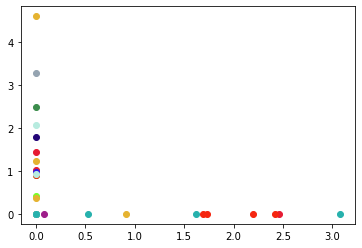

In [189]:
for i, point in enumerate(result_cnn):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print_class(cluster_index)



#5 clusters

In [190]:
import numpy as np
import tensorflow as tf



def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(result_cnn, dtype=tf.float32), num_epochs=1)

num_clusters = 5
kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 100
previous_centers = None
for x in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print ('delta:', cluster_centers - previous_centers)
  previous_centers = cluster_centers
  print ('score:', kmeans.score(input_fn))
print ('cluster centers:', cluster_centers)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb1gc1ny6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

In [191]:
# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(result_cnn):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print ('image:', point, 'is in cluster', cluster_index, 'centered at', center)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb1gc1ny6/model.ckpt-199
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
image: [0.         0.40509966 0.         ... 0.         0.         0.        ] is in cluster 4 centered at [0.07411525 0.09432786 0.42684704 ... 1.5241842  0.2537286  0.27845183]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 4 centered at [0.07411525 0.09432786 0.42684704 ... 1.5241842  0.2537286  0.27845183]
image: [0.         4.590459   0.         ... 0.34289402 0.         0.        ] is in cluster 4 centered at [0.07411525 0.09432786 0.42684704 ... 1.5241842  0.2537286  0.27845183]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 4 centered at [0.07411525 0.09432786 0.42684704 ... 1.5241842  0.2537286  0.27845183]
image: [0. 0. 0. ... 0. 0. 0.] is in cluster 2 centered at [0.13310647 0.10922754 0.6136434  ... 0.00709726 0.060

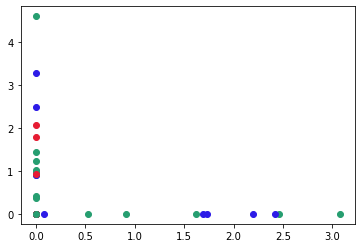

In [192]:
for i, point in enumerate(result_cnn):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print_class(cluster_index)

#**Conclusion**

Nous avons analysé les performances des combinaisons de CNN et de K-Means pour
déterminer les images qui sont en rapport avec le PMA.

Nous avons passé chaque image de cet ensemble de données à travers les
couches convolutionnelles sur CNN. 

Après cela, nous avons utilisé le résultat obtenu lors de la derniére couche du CNN sous forme de matrice à l'algorithme de clustering k-means
pour obtenir le centroïde de chaque cluster qui détermine la
classe de prédiction de chaque point de données (les tests ont été effectué sur 5,10 puis 32 cluster).

 Ce travail nous a notamment  permis de combiner deux méthodes de MLLE ainsi que de souligner la difficulté de classification d'images de façon non supervisée qui reste un domaine encore très compléxeet suggèrent que nos efforts valent la peine d'être poursuivis.

Nous avons réussi a réaliser la majorité des fonctionnalités théorique de base que l'on s'était fixé .

Il reste néanmoins des améliorations à faire afin d'aboutir a un travail finale ainsi qu'a une implémentassions fonctionnelle.

